# Проект: Маркетинг

**Описание**: Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель**: Предсказать вероятность покупки в течение 90 дней

**Данные**:
* *apparel-purchases* - история покупок
* *apparel-messages* - история рекламных рассылок
* *apparel-target_binary* - совершит ли клиент покупку в течение следующих 90 дней

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 25)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import phik
import shap
from datetime import timedelta

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, 
                                   StandardScaler, MinMaxScaler, RobustScaler)

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from catboost             import CatBoostClassifier, Pool
from lightgbm             import LGBMClassifier
from sklearn.tree         import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import RandomForestClassifier

import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)

import time

In [2]:
# создавние класса для стилизации вывода с помощью команды print()
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
# объявление констант
RANDOM_STATE = 1000 # фиксация зерна датчика случайных чисел

In [4]:
# функция для предвариетельного знакомства с таблицей(-ами)
def data_viewer(**dfs):
    for name, dfr in dfs.items():
        print(color.BOLD + color.BLUE + color.UNDERLINE, 'Информация по таблице', name)
        display(dfr.head(5))
        print('Количество пропусков в таблице:' + color.BOLD, dfr.isna().sum().sum(), color.END)
        dups = dfr.duplicated().sum().sum()
        print('Количество явных дубликатов в таблице:', dfr.duplicated().sum().sum())
        print()
        print(dfr.info())
        print()
        
# фкнция для приведения колонок к общепринятому "змеиному" регистру
def camel_to_snake_case(lst):
    updated_columns_list = []
    for col in car_data.columns:
        new_col = []
        for i, letter in enumerate(col):
            if i == 0:
                new_col.append(letter.lower())
            elif letter.isupper():
                new_col.append(f'_{letter.lower()}')
            else:
                new_col.append(letter)
        updated_columns_list.append(''.join(new_col))
    return updated_columns_list
    

# функция для проврки уникальных значений качественных признаков
# я ее использую, чтобы наглядно посмотреть есть ли неявные дубликаты
def unique_check(**dfs):
    for df_name, df in dfs.items():
        categorical = df.select_dtypes('O').columns
        for column in categorical:
            unique_list = df.loc[~df[column].isna(), column].unique()
            print(f'{color.BOLD}Датафрейм {color.BLUE}{df_name}{color.END}{color.BOLD}. \
            \nКолонка {color.BLUE}{column}{color.END + color.BOLD} - ее уникальные значения {color.END}{(sorted(unique_list))}. \
            \nВсего уникальных значений {len(unique_list)}.\n')
        print()

In [5]:
apparel_messages = pd.read_csv('filtered_data/apparel-messages.csv')
apparel_purchases = pd.read_csv('filtered_data/apparel-purchases.csv')
apparel_target_binary = pd.read_csv('filtered_data/apparel-target_binary.csv')
full_campaign_daily_event_channel = pd.read_csv('filtered_data/full_campaign_daily_event_channel.csv')
full_campaign_daily_event = pd.read_csv('filtered_data/full_campaign_daily_event.csv')

In [6]:
data_viewer(apparel_messages=apparel_messages, 
            apparel_purchases=apparel_purchases, 
            apparel_target_binary=apparel_target_binary)

 Информация по таблице apparel_messages


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Количество пропусков в таблице: 0 
Количество явных дубликатов в таблице: 48610

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None

 Информация по таблице apparel_purchases


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Количество пропусков в таблице: 0 
Количество явных дубликатов в таблице: 73020

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None

 Информация по таблице apparel_target_binary


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Количество пропусков в таблице: 0 
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None



Дубликаты в таблице apparel_messages будут удалены.

In [7]:
apparel_messages = apparel_messages.drop_duplicates()

Призакам, характеризующим время, будет присвоен соответствующий тип данных.

In [8]:
apparel_messages['date'] = pd.to_datetime(apparel_messages['date'])
apparel_messages['created_at'] = pd.to_datetime(apparel_messages['created_at'])
apparel_purchases['date'] = pd.to_datetime(apparel_purchases['date'])

Датасет для обучения моделей классификации пользователей будет иметь следующие признаки:
* **main_channel_communication** - основной канал взаимодействия с пользователем
* **mean_message_to_purchase_conversion** - среднее количество покупок с одного рекламного сообщения. Ввиду того, что данный признак будет иметь множество выбросов, кластеризауем его на 3 категории:
    * *one_purchase* - одна покупка
    * *some_purchases* - несколько покупок (от 2 до 5)
    * *a_lot_of_purchases* - много покупок (более 6)
* **average_bill** - средний чек пользователя. Аналогично будет разделен на:
    * *low* - до 700
    * *medium* - от 700 до 2000
    * *high* - от 2000 до 5000
    * *very_high* - более 5000
* Будет создан ряд признаков, характеризующих активность пользователя. Аналогично ввиду того, что данные признаки будут иметь большинство значений равных 0, признаки активности пользователя будут перевены в бинарные (была ли активность последние 100 дней, от 100 до 200, от 200 до 300 итд.). Всего в данных 641 день.
* **open_rate** - частота открытий (количество открытий, отнесенное к количеству полученных сообщений (события open / события send))
* **click_rate** - частота кликов (количество кликов, отнесенное к количеству полученных сообщений (события click / события send))
* **purchase_rate** - частота покупок (количество покупок, отнесенное к количеству полученных сообщений (события purchase / события send))
* **has_error** - наличие ошибок при отправке сообщений 

Предположение: дубликаты в данных таблицы apparel_purchases могли визникнуть из-за ошибки логирования информации корзины покупок, и на самом деле это не дубликат, а пользователь совершил покупку двух единиц товара. Поэтоу признак quantity можно полчинить групиировокой.

In [9]:
grouped_purchase_data = pd.pivot_table(data=apparel_purchases, 
                                       index=['client_id', 'message_id', 'date', 'category_ids', 'price'], 
                                       values=['quantity'], 
                                       aggfunc='sum') \
                          .reset_index()

In [10]:
# основной канал взаимодействия
main_channel_communication = pd.pivot_table(data=apparel_messages, index='client_id', values='channel', aggfunc=lambda x: x.mode().iloc[0])['channel'] \
                               .rename('main_channel_communication')

In [11]:
# издаю отдельную колонку с номером компании для последующей группировки
grouped_purchase_data['campaign_num'] = grouped_purchase_data['message_id'].map(lambda x: x.split('-')[1])

bins = [0, 2, 6, float('inf')]
labels = ['one_purchase', 'some_purchases', 'a_lot_of_purchases']

# среднее количество покупок с одного рекламного сообщения
mean_message_to_purchase_conversion = grouped_purchase_data.groupby(['client_id', 'campaign_num'])['message_id'].count() \
                                                           .reset_index() \
                                                           .groupby('client_id')['message_id'].agg(lambda x: x.mode().iloc[0]) \
                                                           .rename('mean_message_to_purchase_conversion')

mean_message_to_purchase_conversion = pd.cut(mean_message_to_purchase_conversion,
                                             bins=bins,
                                             labels=labels,
                                             right=False)

In [12]:
# среднеий чек каждого пользователя
intermediate_group = grouped_purchase_data.groupby('client_id')['price'].agg(['count', 'sum'])

bins = [0, 700, 2000, 5000, float('inf')]
labels = ['low', 'medium', 'high', 'very_high']
average_bill = pd.cut(round(intermediate_group['sum'] / intermediate_group['count'], 2).rename('average_bill'),
                      bins=bins,
                      labels=labels,
                      right=False)

In [13]:
max(apparel_purchases['date']) - min(apparel_purchases['date'])

Timedelta('641 days 00:00:00')

In [14]:
latest_date = max(apparel_purchases['date'])

days = {}
for hundred_days in range(1, 6):
    days[f'less_{100*hundred_days}_ago'] = latest_date - timedelta(days=100*hundred_days)

def day_markers(date):
    for marker, date_point in days.items():
        if date_point < date:
            return marker
    return 'more_500_days_ago'

In [15]:
grouped_purchase_data['date_markers'] = grouped_purchase_data['date'].apply(day_markers)
grouped_purchase_data['final_price'] = grouped_purchase_data['price'] * grouped_purchase_data['quantity']

marker_date_purchase_data = pd.pivot_table(data=grouped_purchase_data, 
                                           index='client_id', 
                                           columns='date_markers', 
                                           values='final_price', 
                                           aggfunc='sum')

for col in marker_date_purchase_data.columns:
    marker_date_purchase_data.loc[:, col] = marker_date_purchase_data.loc[:, col].map(lambda x: int(x > 0))

In [16]:
event_rate_data = pd.pivot_table(data=apparel_messages, index='client_id', columns='event', values='message_id', aggfunc='count')

event_rate_data['open_rate'] = round(event_rate_data['open'] / event_rate_data['send'], 4)
event_rate_data['click_rate'] = round(event_rate_data['click'] / event_rate_data['send'], 4)
event_rate_data['purchase_rate'] = round(event_rate_data['purchase'] / event_rate_data['send'], 4)
event_rate_data['has_error'] = ((event_rate_data['hard_bounce'] + 
                                                 event_rate_data['soft_bounce']
                                                ) / event_rate_data['send']).map(lambda x: int(x > 0))

In [17]:
df = apparel_target_binary.merge(main_channel_communication, how='left', on='client_id') \
                          .merge(mean_message_to_purchase_conversion, how='left', on='client_id') \
                          .merge(average_bill, how='left', on='client_id') \
                          .merge(event_rate_data[['open_rate', 'click_rate', 'purchase_rate', 'has_error']], 
                                 how='left', on='client_id') \
                          .merge(marker_date_purchase_data, how='left', on='client_id')

In [18]:
df.isna().sum()

client_id                                  0
target                                     0
main_channel_communication              7867
mean_message_to_purchase_conversion        0
average_bill                               0
open_rate                              15103
click_rate                             10392
purchase_rate                          12365
has_error                               7867
less_100_ago                               0
less_200_ago                               0
less_300_ago                               0
less_400_ago                               0
less_500_ago                               0
more_500_days_ago                          0
dtype: int64

In [19]:
df['main_channel_communication'] = df['main_channel_communication'].fillna('unknown')
for col in ['open_rate', 'click_rate', 'purchase_rate', 'has_error']:
    df[col] = df[col].fillna(0)

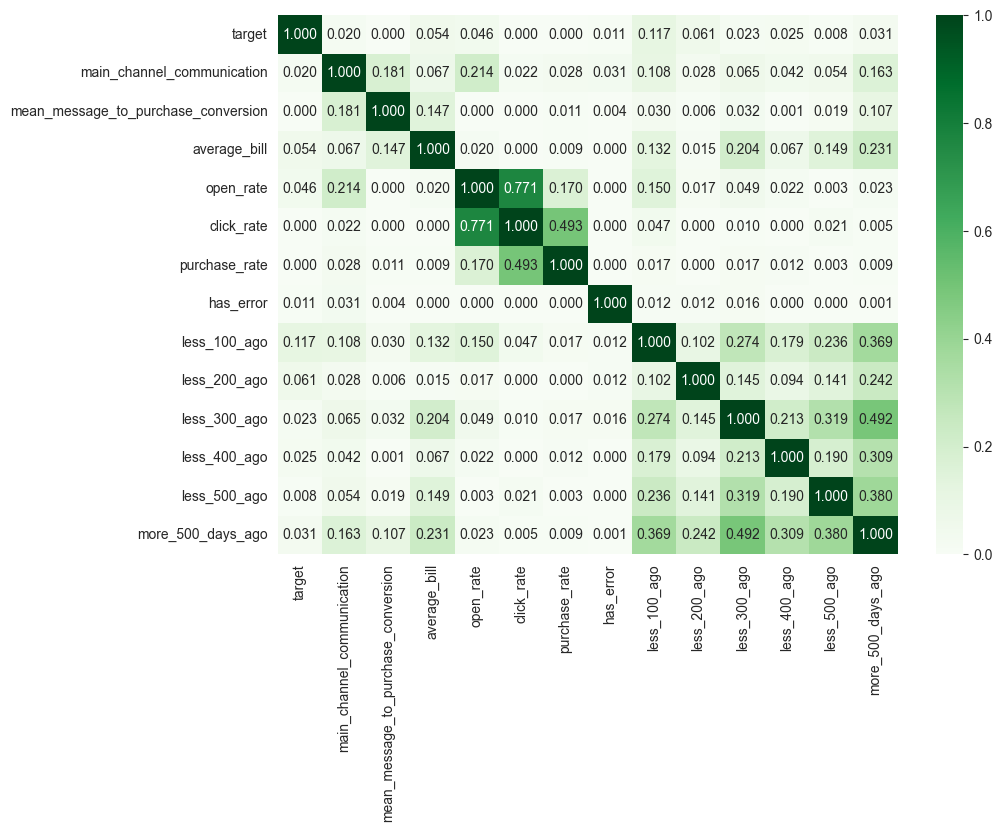

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
phic_matrix = df.drop('client_id', axis=1).phik_matrix(interval_cols=['open_rate',
                                                                      'click_rate', 
                                                                      'purchase_rate']
                                                      )
sns.heatmap(phic_matrix, annot=True, cmap='Greens', fmt=".3f")
plt.show()

Мультиколлинеарность отсутствует, но, к сожалению, зависимость между входными и целевыми признакам - слабая.

## Обучение моделей

In [22]:
start_size = df.shape[0]
df = df[~df.drop('client_id', axis=1).duplicated()]
end_size = df.shape[0]
print(f'После отфильтровывания дубликатов, которые появятся из-за удаления client_id удалено: {start_size - end_size} строк')

После отфильтровывания дубликатов, которые появятся из-за удаления client_id удалено: 8690 строк


In [23]:
X = df.drop(['client_id', 'target'], axis=1)
y = df['target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = RANDOM_STATE)

In [26]:
ohe_cols = ['main_channel_communication',
       'mean_message_to_purchase_conversion', 'average_bill', 'less_100_ago',
       'less_200_ago', 'less_300_ago', 'less_400_ago', 'less_500_ago', 'more_500_days_ago', 'has_error']
num_cols = ['open_rate', 'click_rate', 'purchase_rate']

ohe_pipe = Pipeline([
    (
        'simpleimputer_before_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe', 
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    ),
    (
        'simpleimputer_after_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])

#пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols),
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

In [27]:
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [28]:
param_grid = [
    # словарь для модели DecisionTreeClassifier
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num':['passthrough']            
    },
    # словарь для модели RandomForestClassifier    
    {
    'models': [RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)],

        'preprocessor__num':['passthrough']       
    },    
    # словарь для модели KNeighborsClassifier
    {
        'models':[KNeighborsClassifier()]
    },
        # словарь для модели LGBMClassifier
    {
        'models':[LGBMClassifier(class_weight='balanced', verbose=-1, random_state=RANDOM_STATE)],
        'preprocessor__num':['passthrough']
    },
        # словарь для модели CatBoostClassifier
    {
        'models':[CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=RANDOM_STATE)],
        'preprocessor__num':['passthrough']
    },
        # словарь для модели SGDClassifier
    {
        'models':[SGDClassifier(loss='modified_huber', class_weight='balanced', random_state=RANDOM_STATE)],
    },
    # словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(penalty = 'l1',
                                      solver='saga',
                                      random_state=RANDOM_STATE,
                                      class_weight='balanced')]
    }
]

In [29]:
grid_search_class = GridSearchCV(pipeline, 
                                 param_grid, 
                                 cv=5, 
                                 n_jobs=-1,
                                 scoring='roc_auc')

In [30]:
grid_search_class = grid_search_class.fit(X_train, y_train)

C:\Users\HONOR\.conda\envs\p\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [31]:
class_result = pd.DataFrame(grid_search_class.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
class_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.262808,0.361108,0.049763,0.003807,"LogisticRegression(class_weight='balanced', pe...",NaN,{'models': LogisticRegression(class_weight='ba...,0.742601,0.764092,0.763221,0.746872,0.701038,0.743565,0.022926,1
1,10.992237,0.816586,0.049774,0.001906,"LGBMClassifier(class_weight='balanced', random...",passthrough,{'models': LGBMClassifier(class_weight='balanc...,0.715909,0.691333,0.742022,0.694819,0.714392,0.711695,0.018134,2
2,0.578735,0.041937,0.033300,0.000468,"SGDClassifier(class_weight='balanced', loss='m...",NaN,{'models': SGDClassifier(class_weight='balance...,0.600539,0.719572,0.703822,0.711730,0.639937,0.675120,0.046777,3
3,14.719951,0.251241,0.073546,0.011027,<catboost.core.CatBoostClassifier object at 0x...,passthrough,{'models': <catboost.core.CatBoostClassifier o...,0.663272,0.654839,0.688518,0.647435,0.665156,0.663844,0.013865,4
4,3.118839,0.302303,0.135768,0.028148,RandomForestClassifier(class_weight='balanced'...,passthrough,{'models': RandomForestClassifier(class_weight...,0.653123,0.644553,0.659603,0.666354,0.662258,0.657178,0.007638,5
5,0.211032,0.019448,0.927643,0.089501,KNeighborsClassifier(),NaN,{'models': KNeighborsClassifier()},0.567590,0.575984,0.556212,0.567286,0.558553,0.565125,0.007089,6
6,0.354351,0.006211,0.033462,0.002569,DecisionTreeClassifier(random_state=1000),passthrough,{'models': DecisionTreeClassifier(random_state...,0.523233,0.521004,0.518815,0.520181,0.535187,0.523684,0.005928,7


In [32]:
X_train_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())

Процесс подбора гиперпараметров запускать я не буду, просто перепишу полученные результаты, чтобы сэкономить время.

In [33]:
lgbm_best_params = {'n_estimators': 1050,
 'max_depth': 9,
 'learning_rate': 0.010038630723096272,
 'num_leaves': 20,
 'min_child_samples': 10,
 'subsample': 0.6585058836173159,
 'colsample_bytree': 0.5739986283688562,
 'reg_alpha': 0.027197156836264814,
 'reg_lambda': 6.435036831806752}

logreg_best_params = {'C': 11.661212903718607}

sgdc_best_params = {'loss': 'log_loss',
 'penalty': 'elasticnet',
 'alpha': 0.00044058880163823177,
 'max_iter': 1703,
 'tol': 2.07523442110457e-05,
 'learning_rate': 'adaptive',
 'eta0': 0.04434679764320724,
 'l1_ratio': 0.8882606479370829}

In [34]:
models_dict = {'SGDClassifier': SGDClassifier(**sgdc_best_params, class_weight='balanced',  random_state=RANDOM_STATE),
'LGBMClassifier': LGBMClassifier(**lgbm_best_params, class_weight='balanced', verbose=-1, random_state=RANDOM_STATE),
'LogisticRegression': LogisticRegression(**logreg_best_params, penalty = 'l1', solver='saga', random_state=RANDOM_STATE, class_weight='balanced')}

In [35]:
for name, model in models_dict.items():
    cv_score = cross_val_score(model, X_train_transformed, y_train, cv=5, n_jobs=-1, scoring='roc_auc').mean()
    print(f"ROC-AUC на кросс-валидации для модели {name}: {cv_score:.4f}")

ROC-AUC на кросс-валидации для модели SGDClassifier: 0.7438
ROC-AUC на кросс-валидации для модели LGBMClassifier: 0.7301
ROC-AUC на кросс-валидации для модели LogisticRegression: 0.7436


Целевой метрикой был ROC-AUC > 0,7. Наилучшей моделью по результатам кросс-валидации выбрана SGDClassifier. Именна она будет передана заказчику.

In [36]:
best_sgdc = SGDClassifier(**sgdc_best_params, class_weight='balanced',  random_state=RANDOM_STATE).fit(X_train_transformed, y_train)
probabilities = best_sgdc.predict_proba(X_test_transformed)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)
print(f"ROC-AUC лучшей модели на тестовой выборке: {roc_auc}")

ROC-AUC лучшей модели на тестовой выборке: 0.7080901334806576


# Вывод:

В ходе исследования были созданы признаки как: основной канал взаимодействия с пользователем, среднее количество покупок с одного рекламного сообщения, средний чек пользователя, создан ряд признаков, характеризующих активность пользователя, частота открытий, частота кликов, частота покупок, наличие ошибок при отправке сообщений.

На полученных данных обучены различные модели, для 3 лучших подобраны гиперпарамеры. Итоговой моделью стала SGDClassifier, которая показала 0.708 на тесте.

Также в результате анализа выявлено, что в данных присутствует неоднородность. Часто для пользователя не сходится информация с таблицы apparel_messages и apparel_purchases.

In [37]:
reserch_info = pd.concat([event_rate_data.fillna(0)['purchase'].rename('apparel_messages'), 
                          grouped_purchase_data.groupby('client_id')['message_id'].count().rename('apparel_purchases')], axis=1)

In [38]:
reserch_info[reserch_info.apply(lambda x: ((x['apparel_messages'] == 0) and (x['apparel_purchases'] > 0)
                                          or ((x['apparel_messages'] > 0) and (x['apparel_purchases'] == 0))), axis=1)].shape[0]

4497

In [39]:
ids = reserch_info[reserch_info.apply(lambda x: x['apparel_messages'] == 0 and x['apparel_purchases'] > 0, axis=1)].index

In [40]:
apparel_target_binary['client_id'].isin(ids).sum()

4497

Таких пользователей 4497 штук, из них вcе присутствуют в итоговом датасете apparel_target_binary. Возможно данный фактор мог повлиять на слабы результаты модели, в совокупности с низкой зависимостью между входными признаками и целевыми.